In [1]:
import numpy as np
import imp
import pickle
from scipy.stats import norm
import lmfit

In [2]:
# Initialise wrapper
wrapper_fpath = (r"..\mobius.py")
wr = imp.load_source('mobius', wrapper_fpath)
wr.initialize('../../Applications/SimplyC/simplyc_regional.dll')

# Calibration functions
calib_fpath = (r"..\mobius_calib_uncert_lmfit.py")
cu = imp.load_source('mobius_calib_uncert_lmfit', calib_fpath)

In [3]:


calib_locations = ['Langtjern', 'Storgama', 'Birkenes']

landuse_classes = ['Forest', 'Shrubs', 'Peat']

landuse = {
    'Langtjern' : [73, 5,  22],
    'Storgama'  : [11, 67, 22],
    'Birkenes'  : [90, 3,  7],
}

In [20]:
#NOTE: Here the input file name is only used for structuring, which is fine. No input data is read in
#template_dataset = wr.DataSet.setup_with_blank_index_sets('../../Applications/SimplyC/Storgama/inputs_Storgama.dat')
#template_dataset.set_indexes('Landscape units', landuse_classes)
#template_dataset.set_branch_indexes('Reaches', [('R0', [])])
#template_dataset.set_parameter_uint('Timesteps', [], timesteps)
#template_dataset.set_parameter_time('Start date', [], start_date)

parfile = 'template_pars.dat'
#parfile = 'optimal1.dat'
inputfile = 'template_inputs.dat'
template_dataset = wr.DataSet.setup_from_parameter_and_input_files(parfile, inputfile)

#For now, just run all in 1986-01-01 to 2012-12-31 since it is tricky to have different ranges on them.
timesteps = template_dataset.get_parameter_uint('Timesteps', [])
start_date = template_dataset.get_parameter_time('Start date', [])

param_df = cu.get_double_parameters_as_dataframe(template_dataset, index_short_name={'Forest':'F', 'Shrubs':'S', 'Peat':'P', 'R0':'r0'})
param_df

,name,short_name,unit,index,min_value,initial_value,max_value
0,Latitude,placeholder,°,(),-90.000000,60.000,9.000000e+01
1,Elevation,placeholder,m,(),0.000000,0.000,8.848000e+03
2,PET multiplication factor,alphaPET,dimensionless,(),1.000000,1.280,2.000000e+00
3,Net emissivity at 0 vapor pressure,placeholder,dimensionless,(),0.000000,0.340,1.000000e+00
4,Change in emissivity caused by vapor pressure,placeholder,kPa^{-1/2},(),0.000000,0.139,5.000000e-01
5,Initial snow depth as water equivalent,placeholder,mm,(),0.000000,0.000,5.000000e+04
6,Degree-day factor for snowmelt,DDFmelt,mm/°C/day,(),0.000000,2.740,5.000000e+00
7,Snow melt offset temperature,placeholder,°C,(),-4.000000,0.000,4.000000e+00
8,Temperature at which precipitation falls as snow,placeholder,°C,(),-4.000000,0.000,4.000000e+00
9,Snow fall multiplier,placeholder,dimensionless,(),0.500000,1.000,1.500000e+00


In [26]:

wantparams = [
    'alphaPET', 'DDFmelt', 
    'fquick', 'Ts', 'fc',
    'depthST', 'STC',
    'kT', 'kSO4', 'cDOC', 'baseDOC',
]

#Select all parameters with short_name starting with any of the names in 'wantparams'
calib_df = param_df[[any([sn.startswith(n) for n in wantparams]) for sn in param_df['short_name']]]

calib_df

,name,short_name,unit,index,min_value,initial_value,max_value
2,PET multiplication factor,alphaPET,dimensionless,(),1.00,1.28,2.000
6,Degree-day factor for snowmelt,DDFmelt,mm/°C/day,(),0.00,2.74,5.000
10,Proportion of precipitation that contributes t...,fquick,dimensionless,(),0.00,0.00,1.000
16,Soil water time constant,Ts_F,days,"(Forest,)",0.01,2.00,40.000
17,Soil water time constant,Ts_S,days,"(Shrubs,)",0.01,1.00,40.000
18,Soil water time constant,Ts_P,days,"(Peat,)",0.01,8.00,40.000
19,Soil field capacity,fc_F,mm,"(Forest,)",0.00,200.00,1000.000
20,Soil field capacity,fc_S,mm,"(Shrubs,)",0.00,80.00,1000.000
21,Soil field capacity,fc_P,mm,"(Peat,)",0.00,300.00,1000.000
30,Snow depth / soil temperature factor,depthST,/cm,(),-3.00,-0.20,-0.001


In [29]:
# Convert to LMFit parameter object
params = cu.parameter_df_to_lmfit(calib_df)


params['kT'].min = 0.0
params['kT'].max = 0.2

params['kSO4'].min = 0.0
params['kSO4'].max = 0.2

params['STC_S'].set(expr='STC_F')
params['STC_P'].set(expr='STC_F')

for lu in ['F', 'S', 'P'] :
    params['baseDOC_%s' % lu].min = 1.0
    params['baseDOC_%s' % lu].max = 30.0
    
    params['cDOC_%s' % lu].max = 3.0

#TODO: see if this is ok:
params['cDOC_S'].set(expr='cDOC_F')
params['cDOC_P'].set(expr='cDOC_F')

#params['fquick'].min = 0.0
params['fquick'].max = 0.1

#params['Ts'].max = 5.0

params['alphaPET'].max = 3.0

params

         Consider setting (min < value < max) instead?


name,value,initial value,min,max,vary,expression
alphaPET,1.28000000,1.28,1.00000000,3.00000000,True,
DDFmelt,2.74000000,2.74,0.00000000,5.00000000,True,
fquick,0.00000000,0.0,0.00000000,0.10000000,True,
Ts_F,2.00000000,2.0,0.01000000,40.0000000,True,
Ts_S,1.00000000,1.0,0.01000000,40.0000000,True,
Ts_P,8.00000000,8.0,0.01000000,40.0000000,True,
fc_F,200.000000,200.0,0.00000000,1000.00000,True,
fc_S,80.0000000,80.0,0.00000000,1000.00000,True,
fc_P,300.000000,300.0,0.00000000,1000.00000,True,
depthST,-0.20000000,-0.2,-3.00000000,-1.0000e-03,True,


In [8]:
#These will be used to get physical data along with input time series:
initial_datasets = {}

for loc in calib_locations :
    parfile = '../../Applications/SimplyC/%s/params_%s_regional.dat' % (loc, loc)
    inpfile = '../../Applications/SimplyC/%s/inputs_%s.dat' % (loc, loc)
    initial_datasets[loc] = wr.DataSet.setup_from_parameter_and_input_files(parfile, inpfile)
    
    #NOTE: this is to make everything align up when copying input data below:
    initial_datasets[loc].set_parameter_uint('Timesteps', [], timesteps)
    initial_datasets[loc].set_parameter_time('Start date', [], start_date)

In [9]:
datasets = {}

for loc in calib_locations :
    dataset = template_dataset.copy()
        
    for par in ['Latitude', 'Elevation'] :
        dataset.set_parameter_double(par, [], initial_datasets[loc].get_parameter_double(par, []))
    
    for par in ['Reach length', 'Reach slope', 'Catchment area', 'Initial in-stream flow'] :
        dataset.set_parameter_double(par, ['R0'], initial_datasets[loc].get_parameter_double(par, [loc]))
    
    for idx, lu in enumerate(landuse_classes) :
        dataset.set_parameter_double('Land use proportions', ['R0', lu], landuse[loc][idx]*0.01)   #percentage to 0-1 range
        
    for inp in template_dataset.get_input_list() :
        name, _ = inp
        series = initial_datasets[loc].get_input_series(name, [], alignwithresults=True)
        dataset.set_input_series(name, [], series, alignwithresults=False)
    
    datasets[loc] = dataset

In [10]:
comparisons = [
                ('Reach flow (daily mean, cumecs)', ['R0'], 'Observed flow', []),
                ('Reach DOC concentration (volume weighted daily mean)', ['R0'], 'Observed DOC', []),
                #('DOC flux from reach, daily mean', 'DOC flux', True),
               ]

In [11]:
def normal_weight(series) :
    size = np.count_nonzero(~np.isnan(series))
    return series / np.sqrt(size)

# Custom residual function that takes into account yearly sums as well as daily values
def resid(params, datasets, comparisons, norm=False, skip_timesteps=0) :
    
    residuals = []
    
    for loc in calib_locations :
        
        dataset_copy = datasets[loc].copy()
        cu.set_parameter_values(params, dataset_copy)
        dataset_copy.run_model()

        for i, comparison in enumerate(comparisons):
            simname, simindexes, obsname, obsindexes = comparison

            sim = dataset_copy.get_result_series(simname, simindexes)[skip_timesteps:]
            obs = dataset_copy.get_input_series(obsname, obsindexes, alignwithresults=True)[skip_timesteps:]

            if np.isnan(sim).any() :
                raise ValueError('Got a NaN in the simulated data')

            resid = sim - obs

            #residuals.append(normal_weight(resid))
            residuals.append(resid)

        dataset_copy.delete()   
    
    return np.concatenate(residuals)

Location: Langtjern

Goodness of fit for Reach flow (daily mean, cumecs) [R0] vs Observed flow []:
Mean error (bias): -0.005963
Mean absolute error: 0.012815
Root mean square error: 0.024759
Nash-Sutcliffe coefficient: 0.322578
Number of observations: 9496


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [R0] vs Observed DOC []:
Mean error (bias): -3.257767
Mean absolute error: 3.381995
Root mean square error: 4.184118
Nash-Sutcliffe coefficient: -0.691915
Number of observations: 981

Location: Storgama

Goodness of fit for Reach flow (daily mean, cumecs) [R0] vs Observed flow []:
Mean error (bias): -0.007053
Mean absolute error: 0.012821
Root mean square error: 0.027119
Nash-Sutcliffe coefficient: 0.322914
Number of observations: 9496


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [R0] vs Observed DOC []:
Mean error (bias): -0.222311
Mean absolute error: 1.091343
Root mean square error: 1.355190
Nash-Sutcliffe coefficient: 0.094418

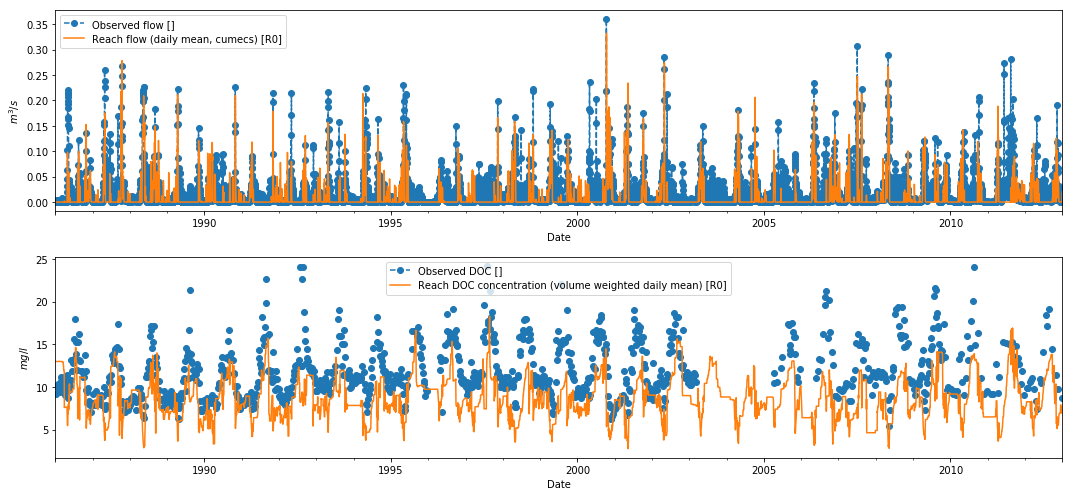

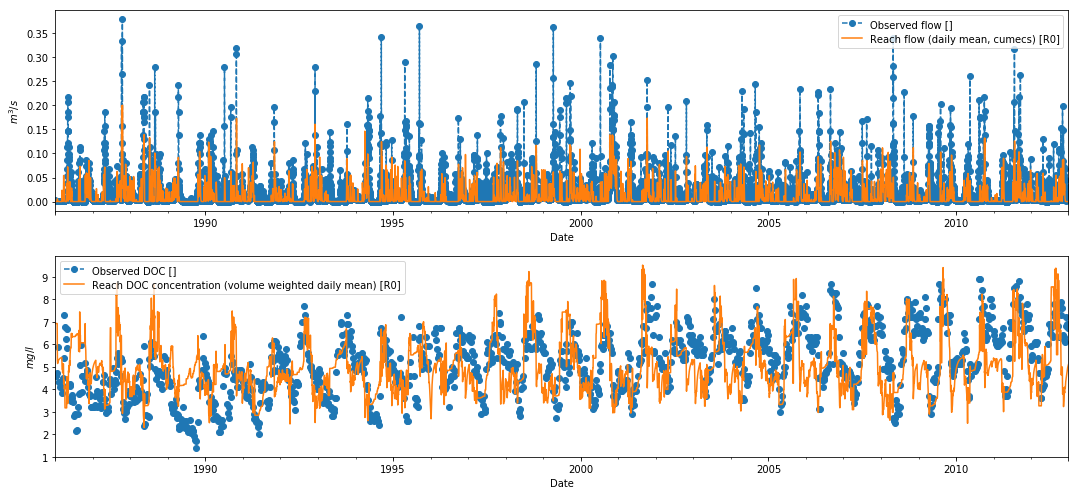

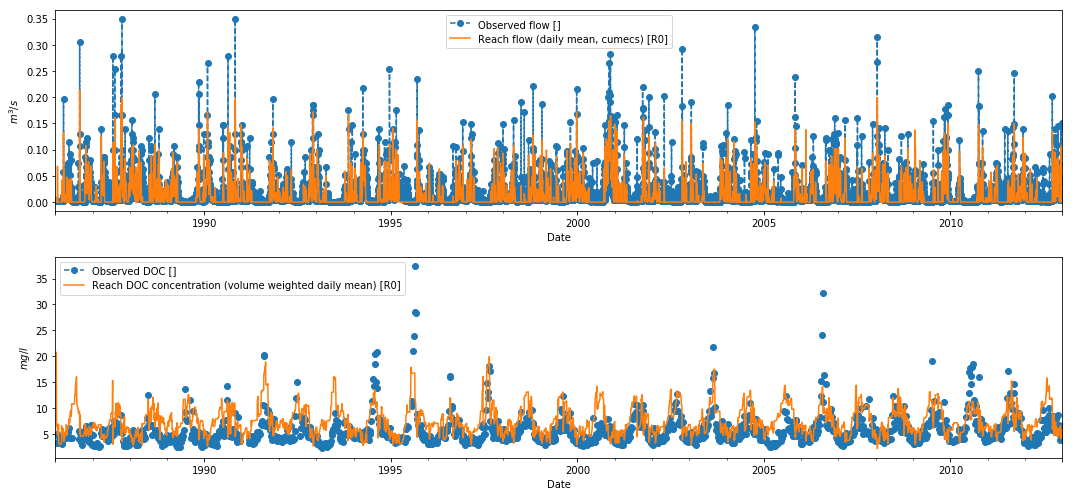

In [12]:
for loc in calib_locations :
    datasets[loc].run_model()
    print('Location: %s' % loc)
    cu.print_goodness_of_fit(datasets[loc], comparisons, skip_timesteps=365)
    cu.plot_objective(datasets[loc], comparisons)

In [13]:
def iter_cb(params, iter, resid, *args, **kws) :
    if iter % 10 == 0 :
        print('Iteration: %d, residual: %g' % (iter, np.nansum(resid*resid)) )
        #params.pretty_print(precision=3)

In [14]:
%%time

mi, res = cu.minimize_residuals(params, datasets, comparisons, residual_method=resid, method='nelder', iter_cb=iter_cb, norm=False, 
                                skip_timesteps=365)

print('Optimisation results:\n')
lmfit.report_fit(res)
print('\n\nOptimised parameter values:\n')
res.params.pretty_print(precision=3)

Iteration: 10, residual: 34927.6
Iteration: 20, residual: 34128.5
Iteration: 30, residual: 35753.8
Iteration: 40, residual: 238477
Iteration: 50, residual: 48032.7
Iteration: 60, residual: 35936
Iteration: 70, residual: 34483
Iteration: 80, residual: 34397.2
Iteration: 90, residual: 34140.8
Iteration: 100, residual: 34120.4
Iteration: 110, residual: 34108.8
Iteration: 120, residual: 34118.8
Iteration: 130, residual: 34101.8
Iteration: 140, residual: 34075.5
Iteration: 150, residual: 34057.3
Iteration: 160, residual: 34024.9
Iteration: 170, residual: 34049.1
Iteration: 180, residual: 33971.9
Iteration: 190, residual: 34822.7
Iteration: 200, residual: 33990
Iteration: 210, residual: 33969.2
Iteration: 220, residual: 33979.3
Iteration: 230, residual: 33940.4
Iteration: 240, residual: 33884.5
Iteration: 250, residual: 33850.1
Iteration: 260, residual: 33796.8
Iteration: 270, residual: 33778.2
Iteration: 280, residual: 33730.1
Iteration: 290, residual: 33669.4
Iteration: 300, residual: 3360

Iteration: 2390, residual: 29602.7
Iteration: 2400, residual: 29602.4
Iteration: 2410, residual: 29602.4
Iteration: 2420, residual: 29602.4
Iteration: 2430, residual: 29603.2
Iteration: 2440, residual: 29603.2
Iteration: 2450, residual: 29602.4
Iteration: 2460, residual: 29603.2
Iteration: 2470, residual: 29602.4
Iteration: 2480, residual: 29602.4
Iteration: 2490, residual: 29604.5
Iteration: 2500, residual: 29602.4
Iteration: 2510, residual: 29602.4
Iteration: 2520, residual: 29602.7
Iteration: 2530, residual: 29602.7
Iteration: 2540, residual: 29604.5
Iteration: 2550, residual: 29602.4
Iteration: 2560, residual: 29602.4
Iteration: 2570, residual: 29602.4
Iteration: 2580, residual: 29602.4
Iteration: 2590, residual: 29644.5
Iteration: 2600, residual: 29602.4
Iteration: 2610, residual: 29603.2
Iteration: 2620, residual: 29602.4
Iteration: 2630, residual: 29644.5
Iteration: 2640, residual: 29602.4
Iteration: 2650, residual: 29602.4
Iteration: 2660, residual: 29602.4
Iteration: 2670, res

Iteration: 4740, residual: 257380
Iteration: 4750, residual: 41730.7
Iteration: 4760, residual: 155348
Iteration: 4770, residual: 159366
Iteration: 4780, residual: 116702
Iteration: 4790, residual: 1.14499e+06
Iteration: 4800, residual: 47042.1
Iteration: 4810, residual: 622233
Iteration: 4820, residual: 181451
Iteration: 4830, residual: 34445.3
Iteration: 4840, residual: 57375.8
Iteration: 4850, residual: 187206
Iteration: 4860, residual: 46633.4
Iteration: 4870, residual: 47931
Iteration: 4880, residual: 119854
Iteration: 4890, residual: 435576
Iteration: 4900, residual: 85753
Iteration: 4910, residual: 83472.6
Iteration: 4920, residual: 80667
Iteration: 4930, residual: 684816
Iteration: 4940, residual: 344089
Iteration: 4950, residual: 693817
Iteration: 4960, residual: 30635.8
Iteration: 4970, residual: 42548.2
Iteration: 4980, residual: 258624
Iteration: 4990, residual: 82215
Iteration: 5000, residual: 36586.1
Iteration: 5010, residual: 29377.1
Iteration: 5020, residual: 135065
Ite

Iteration: 7120, residual: 39327.2
Iteration: 7130, residual: 45051.7
Iteration: 7140, residual: 207427
Iteration: 7150, residual: 59457.5
Iteration: 7160, residual: 100859
Iteration: 7170, residual: 60284.5
Iteration: 7180, residual: 193190
Iteration: 7190, residual: 48648.4
Iteration: 7200, residual: 188385
Iteration: 7210, residual: 29419.3
Iteration: 7220, residual: 29576.1
Iteration: 7230, residual: 30555.5
Iteration: 7240, residual: 29621.7
Iteration: 7250, residual: 32162.6
Iteration: 7260, residual: 27875.8
Iteration: 7270, residual: 30591.9
Iteration: 7280, residual: 31927.9
Iteration: 7290, residual: 29822.9
Iteration: 7300, residual: 27944.3
Iteration: 7310, residual: 31589.7
Iteration: 7320, residual: 36181.4
Iteration: 7330, residual: 29773.1
Iteration: 7340, residual: 30372.1
Iteration: 7350, residual: 38323.9
Iteration: 7360, residual: 153951
Iteration: 7370, residual: 30768.3
Iteration: 7380, residual: 30051.6
Iteration: 7390, residual: 29689.1
Iteration: 7400, residual

Iteration: 9490, residual: 29471.3
Iteration: 9500, residual: 29640.7
Iteration: 9510, residual: 29363
Iteration: 9520, residual: 29453.9
Iteration: 9530, residual: 29719.7
Iteration: 9540, residual: 29575.9
Iteration: 9550, residual: 29410.5
Iteration: 9560, residual: 29556
Iteration: 9570, residual: 29407.7
Iteration: 9580, residual: 29422.9
Iteration: 9590, residual: 29784.8
Iteration: 9600, residual: 31027.8
Iteration: 9610, residual: 42107.8
Iteration: 9620, residual: 29656.6
Iteration: 9630, residual: 29696.9
Iteration: 9640, residual: 29591.2
Iteration: 9650, residual: 29358
Iteration: 9660, residual: 32054.3
Iteration: 9670, residual: 29668.1
Iteration: 9680, residual: 29650.8
Iteration: 9690, residual: 29694.1
Iteration: 9700, residual: 113837
Iteration: 9710, residual: 124237
Iteration: 9720, residual: 124273
Iteration: 9730, residual: 123224
Iteration: 9740, residual: 123569
Iteration: 9750, residual: 30750.2
Iteration: 9760, residual: 42291.6
Iteration: 9770, residual: 2925

C:\Users\magnu\AppData\Roaming\Python\Python37\site-packages\numdifftools\limits.py:182: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  f_del = np.vstack(list(np.ravel(r)) for r in sequence)
C:\Users\magnu\AppData\Roaming\Python\Python37\site-packages\numdifftools\limits.py:184: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for step in steps)
C:\Program Files\Python37\lib\site-packages\lmfit\minimizer.py:787: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
C:\Program Files\Python37\lib\site-packages\lmfit\minimizer.py:780: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.r

In [15]:
print('Optimisation results:\n')
lmfit.report_fit(res)
print('\n\nOptimised parameter values:\n')
res.params.pretty_print(precision=3)

Optimisation results:

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 4634
    # data points      = 32104
    # variables        = 15
    chi-square         = 29602.3380
    reduced chi-square = 0.92250734
    Akaike info crit   = -2574.51049
    Bayesian info crit = -2448.85945
##  Warning: uncertainties could not be estimated:
    fquick:    at initial value
    fquick:    at boundary
[[Variables]]
    alphaPET:  1.21484510 +/- 0.00457949 (0.38%) (init = 1.259922)
    DDFmelt:   2.69862939 +/-        nan (nan%) (init = 2.695089)
    fquick:    9.4903e-11 +/-        nan (nan%) (init = 4.232465e-11)
    fc:        123.831045 +/- 0.76373184 (0.62%) (init = 110.4255)
    Ts_F:      1.68667053 +/-        nan (nan%) (init = 1.670581)
    Ts_S:      1.84254358 +/-        nan (nan%) (init = 2.049233)
    Ts_B:      1.78600043 +/-        nan (nan%) (init = 1.961818)
    sdst:     -1.25557156 +/- 0.05723831 (4.56%) (init = -1.383018)
    Stc_F:     0.06149405 

Location: Langtjern

Goodness of fit for Reach flow (daily mean, cumecs) [R0] vs Observed flow []:
Mean error (bias): -0.005934
Mean absolute error: 0.012857
Root mean square error: 0.024803
Nash-Sutcliffe coefficient: 0.320170
Number of observations: 9496


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [R0] vs Observed DOC []:
Mean error (bias): -3.037455
Mean absolute error: 3.270718
Root mean square error: 4.033210
Nash-Sutcliffe coefficient: -0.572072
Number of observations: 981

Location: Storgama

Goodness of fit for Reach flow (daily mean, cumecs) [R0] vs Observed flow []:
Mean error (bias): -0.006999
Mean absolute error: 0.012892
Root mean square error: 0.027117
Nash-Sutcliffe coefficient: 0.323048
Number of observations: 9496


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [R0] vs Observed DOC []:
Mean error (bias): -0.133840
Mean absolute error: 1.100565
Root mean square error: 1.385721
Nash-Sutcliffe coefficient: 0.053154

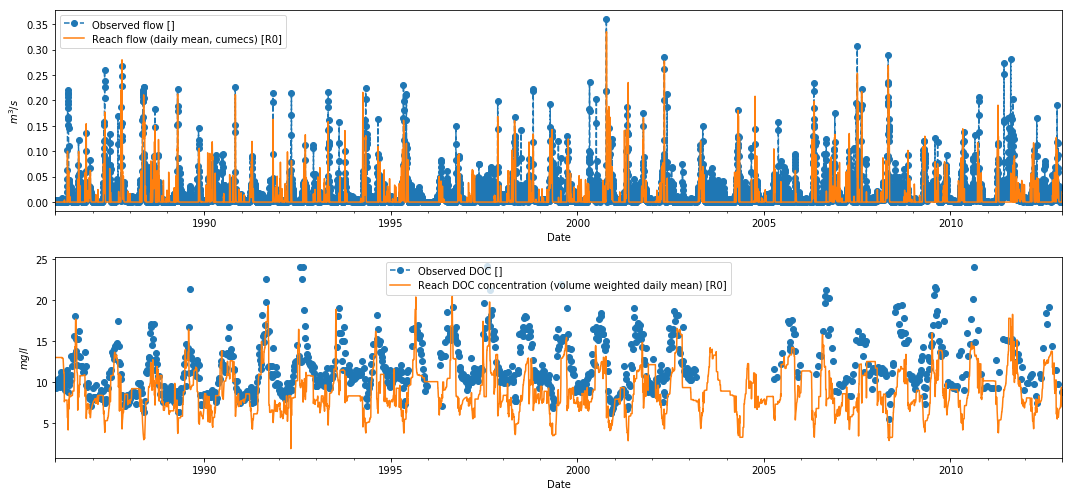

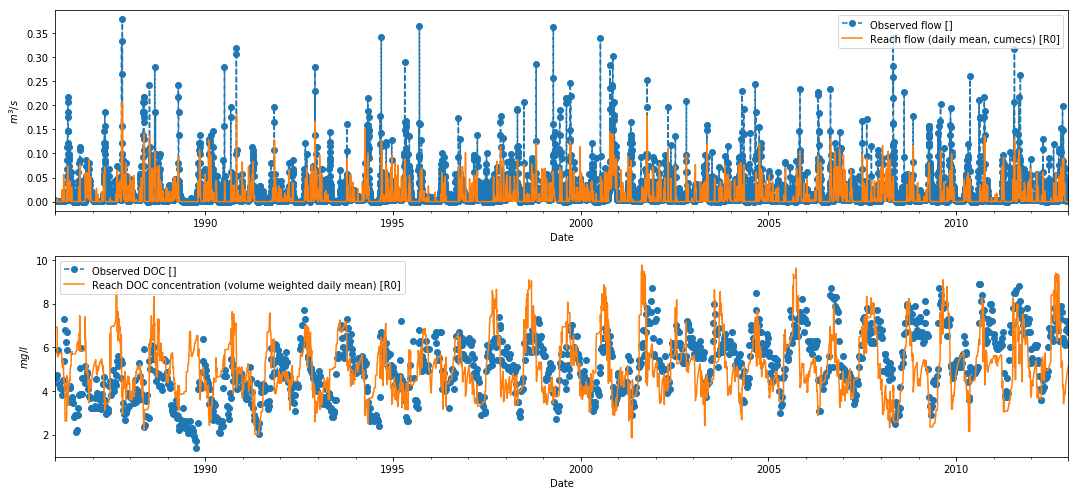

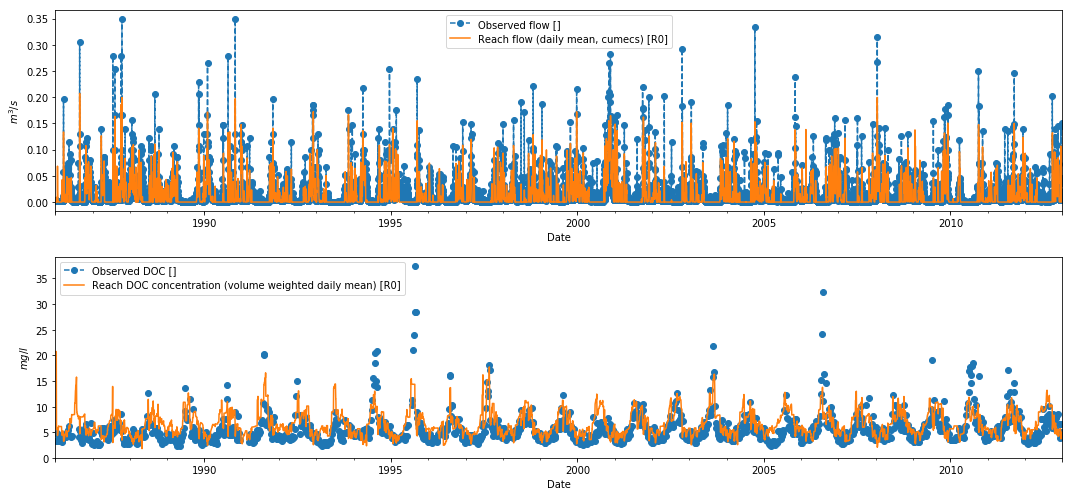

In [16]:
for loc in calib_locations :
    cu.set_parameter_values(res.params, datasets[loc])
    datasets[loc].run_model()
    print('Location: %s' % loc)
    cu.print_goodness_of_fit(datasets[loc], comparisons, skip_timesteps=365)
    cu.plot_objective(datasets[loc], comparisons)

In [17]:
datasets['Langtjern'].write_parameters_to_file('optimal3.dat')